# Contextual Emotion Detection


## 1. Loading Data

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

Dataset link: 

In [2]:
def load_dataset(filename):
  df = pd.read_csv(filename)
  label = df["label"]
  unique_label = list(set(label))
  sentences = list(df["text"])
  
  return (df, label, unique_label, sentences)

In [3]:
df, label, unique_label, sentences = load_dataset('iseardataset.csv')

In [4]:
print(unique_label)

['disgust', 'fear', 'anger', 'joy', 'guilt', 'shame', 'sadness']


In [5]:
print(df.head(10))

     label                                               text Unnamed: 2
0      joy  On days when I feel close to my partner and ot...        NaN
1     fear  Every time I imagine that someone I love or I ...        NaN
2    anger  When I had been obviously unjustly treated and...        NaN
3  sadness  When I think about the short time that we live...        NaN
4  disgust  At a gathering I found myself involuntarily si...        NaN
5    shame  When I realized that I was directing the feeli...        NaN
6    guilt  I feel guilty when when I realize that I consi...        NaN
7      joy  After my girlfriend had taken her exam we went...        NaN
8     fear  When, for the first time I realized the meanin...        NaN
9    anger  When a car is overtaking another and I am forc...        NaN


<AxesSubplot:xlabel='label', ylabel='count'>

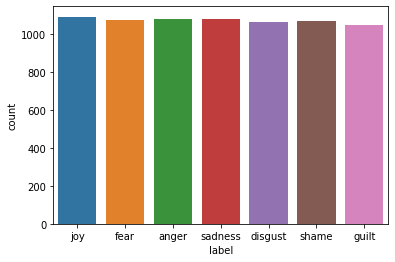

In [6]:
import seaborn as sns
import tkinter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x="label", data=df)

In [7]:
print(sentences[:5])

['On days when I feel close to my partner and other friends.   \nWhen I feel at peace with myself and also experience a close  \ncontact with people whom I regard greatly.', 'Every time I imagine that someone I love or I could contact a  \nserious illness, even death.', 'When I had been obviously unjustly treated and had no possibility  \nof elucidating this.', 'When I think about the short time that we live and relate it to  \nthe periods of my life when I think that I did not use this  \nshort time.', 'At a gathering I found myself involuntarily sitting next to two  \npeople who expressed opinions that I considered very low and  \ndiscriminating.']


In [8]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shiningflash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/shiningflash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Data Cleaning

In [9]:
#define stemmer
stemmer = LancasterStemmer()

In [10]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    words.append([i.lower() for i in w])
    
  return words 

In [11]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  

7516
[['on', 'days', 'when', 'i', 'feel', 'close', 'to', 'my', 'partner', 'and', 'other', 'friends', 'when', 'i', 'feel', 'at', 'peace', 'with', 'myself', 'and', 'also', 'experience', 'a', 'close', 'contact', 'with', 'people', 'whom', 'i', 'regard', 'greatly'], ['every', 'time', 'i', 'imagine', 'that', 'someone', 'i', 'love', 'or', 'i', 'could', 'contact', 'a', 'serious', 'illness', 'even', 'death']]


## 3. Texts Tokenization

In [12]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [13]:
def max_length(words):
  return(len(max(words, key = len)))

In [14]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 8989 and Maximum length = 179


In [15]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [16]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [17]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [18]:
padded_doc = padding_doc(encoded_doc, max_length)

In [19]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (7516, 179)


In [20]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_label, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [21]:
output_tokenizer.word_index

{'disgust': 1,
 'fear': 2,
 'anger': 3,
 'joy': 4,
 'guilt': 5,
 'shame': 6,
 'sadness': 7}

In [22]:
encoded_output = encoding_doc(output_tokenizer, label)

In [23]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [24]:
encoded_output.shape

(7516, 1)

In [25]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [26]:
output_one_hot = one_hot(encoded_output)

In [27]:
output_one_hot.shape

(7516, 7)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [30]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (6012, 179) and train_Y = (6012, 7)
Shape of val_X = (1504, 179) and val_Y = (1504, 7)


## 4. Bidirectional GRU 

In [31]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(GRU(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = "softmax"))
  
  return model

In [32]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 179, 128)          1150592   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               198144    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 1,357,191
Trainable params: 206,599
Non-trainable params: 1,150,592
_________________________________________________________________


In [33]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [34]:
hist = model.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [checkpoint])

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 1.9452 - accuracy: 0.1565
Epoch 00001: val_loss improved from inf to 1.93838, saving model to model.h5
188/188 [==============================] - 28s 147ms/step - loss: 1.9452 - accuracy: 0.1565 - val_loss: 1.9384 - val_accuracy: 0.1868
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 1.9222 - accuracy: 0.1919
Epoch 00002: val_loss improved from 1.93838 to 1.87944, saving model to model.h5
188/188 [==============================] - 30s 157ms/step - loss: 1.9222 - accuracy: 0.1919 - val_loss: 1.8794 - val_accuracy: 0.2374
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 1.8723 - accuracy: 0.2399
Epoch 00003: val_loss improved from 1.87944 to 1.84961, saving model to model.h5
188/188 [==============================] - 31s 162ms/step - loss: 1.8723 - accuracy: 0.2399 - val_loss: 1.8496 - val_accuracy: 0.2646
Epoch 4/100
188/188 [==============================] - ETA: 0s - los

Epoch 57/100
188/188 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.7636
Epoch 00057: val_loss did not improve from 1.55276
188/188 [==============================] - 28s 147ms/step - loss: 0.6227 - accuracy: 0.7636 - val_loss: 2.9346 - val_accuracy: 0.4195
Epoch 58/100
188/188 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.7754
Epoch 00058: val_loss did not improve from 1.55276
188/188 [==============================] - 28s 151ms/step - loss: 0.5814 - accuracy: 0.7754 - val_loss: 3.0307 - val_accuracy: 0.4182
Epoch 59/100
188/188 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.7884
Epoch 00059: val_loss did not improve from 1.55276
188/188 [==============================] - 28s 149ms/step - loss: 0.5541 - accuracy: 0.7884 - val_loss: 3.0622 - val_accuracy: 0.4189
Epoch 60/100
188/188 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7824
Epoch 00060: val_loss did not improve from 1.55276
18

Epoch 86/100
188/188 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8734
Epoch 00086: val_loss did not improve from 1.55276
188/188 [==============================] - 30s 159ms/step - loss: 0.3257 - accuracy: 0.8734 - val_loss: 4.2445 - val_accuracy: 0.4315
Epoch 87/100
188/188 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.8648
Epoch 00087: val_loss did not improve from 1.55276
188/188 [==============================] - 30s 160ms/step - loss: 0.3569 - accuracy: 0.8648 - val_loss: 4.5867 - val_accuracy: 0.4129
Epoch 88/100
188/188 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8861
Epoch 00088: val_loss did not improve from 1.55276
188/188 [==============================] - 31s 162ms/step - loss: 0.2930 - accuracy: 0.8861 - val_loss: 4.7156 - val_accuracy: 0.4235
Epoch 89/100
188/188 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.8970
Epoch 00089: val_loss did not improve from 1.55276
18

## 5. Bidirectional LSTM 

In [37]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = "softmax"))
  
  return model

model_lstm = create_model(vocab_size, max_length)

model_lstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 179, 128)          1150592   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 231       
Total params: 1,422,215
Trainable params: 271,623
Non-trainable params: 1,150,592
_________________________________________________________________


In [38]:
filename = 'model_lstm.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

hist = model_lstm.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [checkpoint])

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 1.9454 - accuracy: 0.1504
Epoch 00001: val_loss improved from inf to 1.93586, saving model to model_lstm.h5
188/188 [==============================] - 42s 223ms/step - loss: 1.9454 - accuracy: 0.1504 - val_loss: 1.9359 - val_accuracy: 0.1822
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 1.9173 - accuracy: 0.1964
Epoch 00002: val_loss improved from 1.93586 to 1.90459, saving model to model_lstm.h5
188/188 [==============================] - 39s 207ms/step - loss: 1.9173 - accuracy: 0.1964 - val_loss: 1.9046 - val_accuracy: 0.2367
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 1.8735 - accuracy: 0.2442
Epoch 00003: val_loss improved from 1.90459 to 1.83846, saving model to model_lstm.h5
188/188 [==============================] - 38s 203ms/step - loss: 1.8735 - accuracy: 0.2442 - val_loss: 1.8385 - val_accuracy: 0.2819
Epoch 4/100
188/188 [==============================] 

Epoch 29/100
188/188 [==============================] - ETA: 0s - loss: 1.3540 - accuracy: 0.5035
Epoch 00029: val_loss did not improve from 1.61430
188/188 [==============================] - 44s 234ms/step - loss: 1.3540 - accuracy: 0.5035 - val_loss: 1.7095 - val_accuracy: 0.3850
Epoch 30/100
188/188 [==============================] - ETA: 0s - loss: 1.3552 - accuracy: 0.4960
Epoch 00030: val_loss did not improve from 1.61430
188/188 [==============================] - 43s 228ms/step - loss: 1.3552 - accuracy: 0.4960 - val_loss: 1.6465 - val_accuracy: 0.3949
Epoch 31/100
188/188 [==============================] - ETA: 0s - loss: 1.3172 - accuracy: 0.5093
Epoch 00031: val_loss did not improve from 1.61430
188/188 [==============================] - 47s 250ms/step - loss: 1.3172 - accuracy: 0.5093 - val_loss: 1.6255 - val_accuracy: 0.3863
Epoch 32/100
188/188 [==============================] - ETA: 0s - loss: 1.2844 - accuracy: 0.5206
Epoch 00032: val_loss did not improve from 1.61430
18

Epoch 58/100
188/188 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.6617
Epoch 00058: val_loss did not improve from 1.61430
188/188 [==============================] - 36s 191ms/step - loss: 0.9007 - accuracy: 0.6617 - val_loss: 2.1213 - val_accuracy: 0.4142
Epoch 59/100
188/188 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.6620
Epoch 00059: val_loss did not improve from 1.61430
188/188 [==============================] - 37s 196ms/step - loss: 0.9012 - accuracy: 0.6620 - val_loss: 1.9507 - val_accuracy: 0.3969
Epoch 60/100
188/188 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.6702
Epoch 00060: val_loss did not improve from 1.61430
188/188 [==============================] - 36s 190ms/step - loss: 0.8808 - accuracy: 0.6702 - val_loss: 2.2631 - val_accuracy: 0.4082
Epoch 61/100
188/188 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.6612
Epoch 00061: val_loss did not improve from 1.61430
18

Epoch 87/100
188/188 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.7611
Epoch 00087: val_loss did not improve from 1.61430
188/188 [==============================] - 36s 192ms/step - loss: 0.6282 - accuracy: 0.7611 - val_loss: 2.9247 - val_accuracy: 0.3903
Epoch 88/100
188/188 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.7834
Epoch 00088: val_loss did not improve from 1.61430
188/188 [==============================] - 40s 211ms/step - loss: 0.5527 - accuracy: 0.7834 - val_loss: 3.2278 - val_accuracy: 0.4043
Epoch 89/100
188/188 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.7904
Epoch 00089: val_loss did not improve from 1.61430
188/188 [==============================] - 39s 206ms/step - loss: 0.5499 - accuracy: 0.7904 - val_loss: 3.1070 - val_accuracy: 0.4149
Epoch 90/100
188/188 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7615
Epoch 00090: val_loss did not improve from 1.61430
18

In [39]:
model = load_model("model.h5")

In [40]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)

  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)

  pred = model.predict(x)
  
  return pred

In [41]:
def get_final_output(pred, classes):
  predictions = pred[0]
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
  
  return classes[0]

In [43]:
text = "I did not help out enough at my thesis team."
pred = predictions(text)
result = get_final_output(pred, unique_label)
print('\nans: {}\n'.format(result))

guilt has confidence = 0.60942477
shame has confidence = 0.3327749
anger has confidence = 0.028819958
sadness has confidence = 0.01870823
disgust has confidence = 0.005583318
joy has confidence = 0.002525375
fear has confidence = 0.0021633662

ans: guilt



In [44]:
text = "When someone stole my bike."
pred = predictions(text)
result = get_final_output(pred, unique_label)
print('\nans: {}\n'.format(result))

anger has confidence = 0.4896557
disgust has confidence = 0.22202596
guilt has confidence = 0.14396228
shame has confidence = 0.08689866
sadness has confidence = 0.04276661
joy has confidence = 0.009014194
fear has confidence = 0.0056765988

ans: anger



In [47]:
text = "When my girlfriend left me."
pred = predictions(text)
result = get_final_output(pred, unique_label)
print('\nans: {}\n'.format(result))

sadness has confidence = 0.68341756
joy has confidence = 0.102982506
anger has confidence = 0.0767743
disgust has confidence = 0.04667361
guilt has confidence = 0.043792434
shame has confidence = 0.029173799
fear has confidence = 0.01718583

ans: sadness



In [48]:
text = "During the Christmas holidays, I met some of my old friends."
pred = predictions(text)
result = get_final_output(pred, unique_label)
print('\nans: {}\n'.format(result))

joy has confidence = 0.63931054
shame has confidence = 0.123251356
sadness has confidence = 0.09643768
guilt has confidence = 0.058223043
fear has confidence = 0.04968705
disgust has confidence = 0.021635186
anger has confidence = 0.011455217

ans: joy

